# Final Project: Predict Future Sales

In [129]:
library(dplyr)
library(ggplot2)
library(scales)
library(forecast)
library(lubridate)
library(boot)

In [130]:
item_categories = read.csv("C:/Users/hanis/OneDrive/2023 NJIT SUMMER SEMESTER/Data Analytics R/Final Project/item_categories.csv")
items = read.csv("C:/Users/hanis/OneDrive/2023 NJIT SUMMER SEMESTER/Data Analytics R/Final Project/items.csv")
sales_train = read.csv("C:/Users/hanis/OneDrive/2023 NJIT SUMMER SEMESTER/Data Analytics R/Final Project/sales_train.csv")
sample_submission = read.csv("C:/Users/hanis/OneDrive/2023 NJIT SUMMER SEMESTER/Data Analytics R/Final Project/sample_submission.csv")
shops = read.csv("C:/Users/hanis/OneDrive/2023 NJIT SUMMER SEMESTER/Data Analytics R/Final Project/shops.csv")
test = read.csv("C:/Users/hanis/OneDrive/2023 NJIT SUMMER SEMESTER/Data Analytics R/Final Project/test.csv")

In [131]:
head(sales_train)
max(sales_train$item_cnt_day)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
1,02.01.2013,0,59,22154,999.00,1
2,03.01.2013,0,25,2552,899.00,1
3,05.01.2013,0,25,2552,899.00,-1
4,06.01.2013,0,25,2554,1709.05,1
5,15.01.2013,0,25,2555,1099.00,1
6,10.01.2013,0,25,2564,349.00,1


[1] 2169

# Exploratory Analysis

In [132]:
summary(items)

  item_name            item_id      item_category_id
 Length:22170       Min.   :    0   Min.   : 0.00   
 Class :character   1st Qu.: 5542   1st Qu.:37.00   
 Mode  :character   Median :11084   Median :40.00   
                    Mean   :11084   Mean   :46.29   
                    3rd Qu.:16627   3rd Qu.:58.00   
                    Max.   :22169   Max.   :83.00   

In [133]:
summary(sales_train)  
#negative values for price and item_cnt_day... need to clean

     date           date_block_num     shop_id      item_id     
 Length:2935849     Min.   : 0.00   Min.   : 0   Min.   :    0  
 Class :character   1st Qu.: 7.00   1st Qu.:22   1st Qu.: 4476  
 Mode  :character   Median :14.00   Median :31   Median : 9343  
                    Mean   :14.57   Mean   :33   Mean   :10197  
                    3rd Qu.:23.00   3rd Qu.:47   3rd Qu.:15684  
                    Max.   :33.00   Max.   :59   Max.   :22169  
   item_price        item_cnt_day     
 Min.   :    -1.0   Min.   : -22.000  
 1st Qu.:   249.0   1st Qu.:   1.000  
 Median :   399.0   Median :   1.000  
 Mean   :   890.9   Mean   :   1.243  
 3rd Qu.:   999.0   3rd Qu.:   1.000  
 Max.   :307980.0   Max.   :2169.000  

In [134]:
sales_train[sales_train$item_price <0,]    #1 record 
#sales_train[sales_train$item_cnt_day <0,]  #7k records 
#clean
sales_train = sales_train[sales_train$item_price>=0,]     
sales_train = sales_train[sales_train$item_cnt_day >=0,]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
484684,15.05.2013,4,32,2973,-1,1


### Count of Items by Category Plot

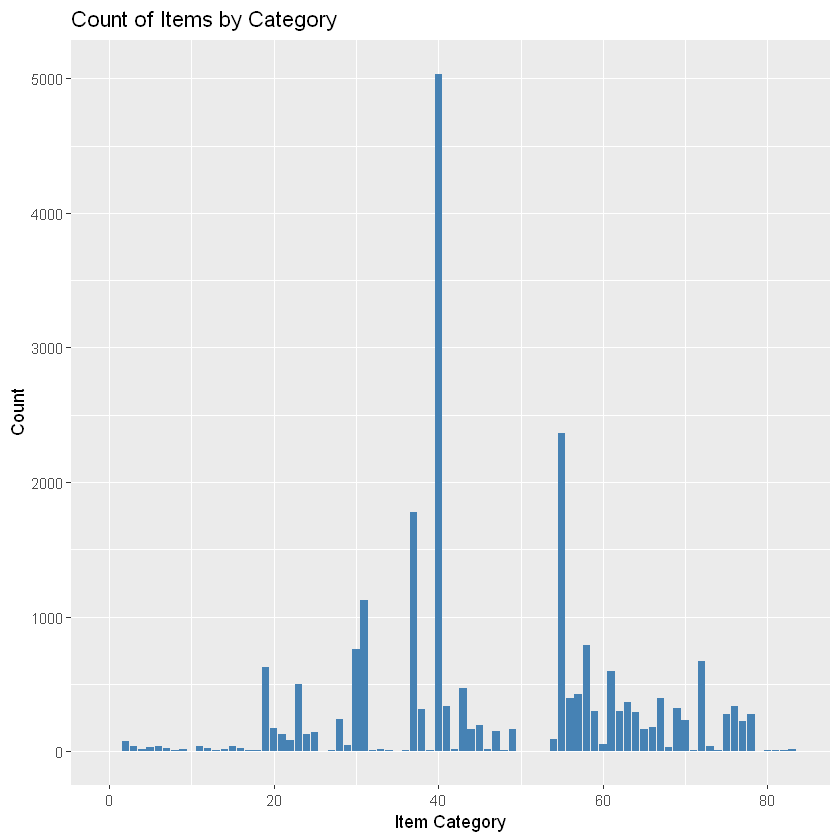

In [135]:
items_grouped = items %>% group_by(item_category_id) %>% summarize(count = n())
ggplot(items_grouped, aes(x = item_category_id, y = count)) +
  geom_bar(stat = "identity",  fill = "steelblue") +
  labs(x = "Item Category", y = "Count", title = "Count of Items by Category")

### Items Sold by Month Plot

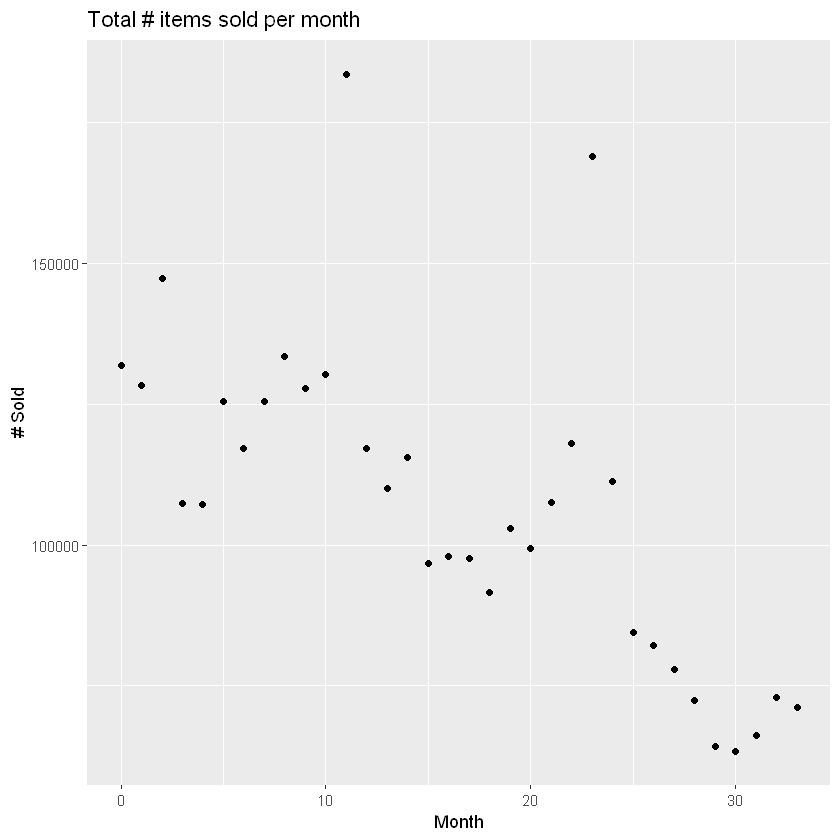

In [136]:
items_bymonth = sales_train %>% group_by(date_block_num) %>% summarize(s = sum(item_cnt_day))

ggplot(items_bymonth, aes(x = date_block_num, y = s)) +
  geom_point() +
  labs(x = "Month", y = "# Sold", title = "Total # items sold per month")

General negative trend in quantity of products sold over time 

### Total Sales by Month

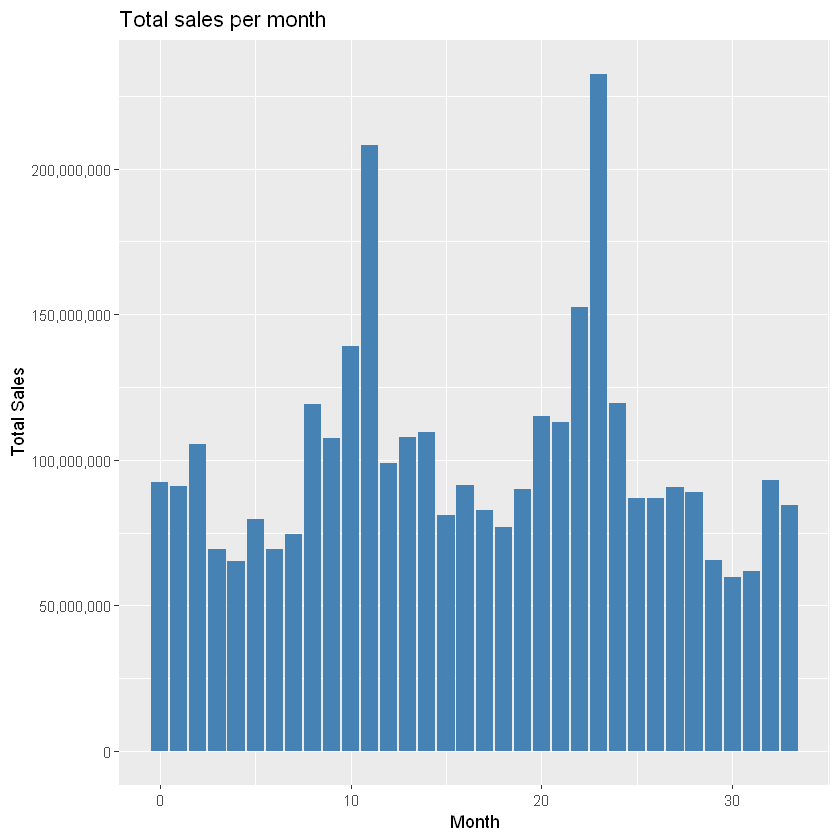

In [137]:
sales_train = mutate(sales_train, sales = item_price*item_cnt_day)
sales_by_month = sales_train %>% group_by(date_block_num) %>% summarize(s = sum(sales))
colnames(sales_by_month)[1] = "month"

ggplot(sales_by_month, aes(x = month, y = s)) +
  geom_bar(stat = "identity",  fill = "steelblue") +
  labs(x = "Month", y = "Total Sales", title = "Total sales per month")+
  scale_y_continuous(labels = comma)

Despite few months with really really high sales, has mostly hovered around  ~$100k

## Cleaning and Model Building

In [138]:
#need IDs in training dataframe... pull from test dataframe
sales_train = left_join(sales_train, test, by = c("shop_id","item_id"))
#some IDs are not in the test set for prediction...discard these in training set 
sales_train = sales_train %>%filter(!is.na(ID))
#create month column "month_x" so Jan 2013 is 1 and Jan 2014 = 13, for example
sales_train$date = dmy(sales_train$date)
sales_train$month = month(sales_train$date)
sales_train$year = year(sales_train$date)
sales_train$month_x =  12 * (sales_train$year - 2013) + sales_train$month

In [139]:
grouped_counts <- sales_train %>%
  group_by(ID) %>%
  summarise(row_count = n()) 
grouped_counts = grouped_counts[grouped_counts$row_count>1,]

all_ids = unique(grouped_counts$ID)
all_ids = sort(all_ids)

predictions = c()
deltas=c()

In [ ]:
for (i in all_ids){
  #filter so only training examples of i ID
  df = sales_train[sales_train$ID == i,]
  
  #create lm model for i ID
  model = glm(item_cnt_day~month_x, data=df)
  cv_results = cv.glm(data = df, glmfit = model)
  d = cv_results$delta
  deltas = c(deltas,d)
  
  #predict for next month
  newdata = data.frame(month_x = 35)
  newp = predict(model,newdata)
  #store in vector
  predictions = c(predictions, newp)
}

In [140]:
#reading in outputs of above loop... Jupyter notebooks was taking extremely long to run, and I had already completed this in R studio
predictions = readRDS("predictions.rds")
deltas = readRDS("deltas.rds")

In [141]:
#clean final prediction
pred = data.frame(ID = all_ids, item_cnt_month=predictions)
pred$item_cnt_month = format(pred$item_cnt_month, scientific = FALSE)
final_df = left_join(sample_submission,pred,by="ID")
final_df$item_cnt_month.x=NULL
names(final_df)[2]= "item_cnt_month"
final_df$item_cnt_month = as.integer(final_df$item_cnt_month)
final_df$item_cnt_month = ifelse(is.na(final_df$item_cnt_month)|final_df$item_cnt_month < 0, 0, final_df$item_cnt_month)

In [142]:
#final prediction dataframe
head(final_df,10)

,ID,item_cnt_month
,<int>,<dbl>
1,0,1
2,1,0
3,2,0
4,3,0
5,4,0
6,5,1
7,6,0
8,7,0
9,8,0


In [143]:
#There are 2 assumptions made
#1. Not all test set IDs have historical data in the training set (new item/shop combination)
#I updated any NAs to be 0 -- these unique shop/item combinations(IDs) never had any past sales... expect them to continue not having any 
#2. The model predicts negative sales for some variables 
#I updated any negative values to be 0, or no sales are predicted at all
#Overall, I believe this is an average prediction...Using previous monthly trends to help predict the next month for each individual ID makes sense and should yield decent performance
#Performance metrics discussed later when comparing this to the improved model
#However, as discussed earlier, this does not take into consideration any new ID

In [144]:
#To further improve the model, I will focus on feature selection. Currently, I am only using time as a feature. 
#I will add current price to the model. Since big ticket items are typically purchased with less frequency, this makes sense to include in the updated model.
#This will now be a multiple linear regression implementation. 

In [145]:
grouped_counts2 <- sales_train %>%
  group_by(ID) %>%
  summarise(row_count = n()) 
grouped_counts2 = grouped_counts2[grouped_counts2$row_count>3,]


In [146]:
all_ids2 = unique(grouped_counts2$ID)
all_ids2 = sort(all_ids2)

l = sales_train[sales_train$ID %in% all_ids2,]
l = l %>% group_by(ID) %>% summarize(unique_months = n_distinct(month_x)) 
l = l[l$unique_months>3,]
all_ids2.2 = l$ID

ids2 = all_ids2.2[all_ids2.2 %in% all_ids2]

predictions2 = c()
deltas2=c()

In [ ]:
for (i in ids2){
  #filter so only training examples of i ID
  df = sales_train[sales_train$ID == i,]
  
  #aggregate month sales for i ID
  y = group_by(df, month_x) %>% summarize(sum(item_cnt_day))
  colnames(y)[2] ="sales_count"
  df2 = left_join(y,df,by="month_x")
  df2 = df2[c("month_x","sales_count", "item_price")]
  
  #some months have multiple prices (changed during month), so take average price 
  g = df2 %>% group_by(month_x) %>% summarize(mean(item_price))
  df2 = df2 %>% distinct(month_x, .keep_all = TRUE)
  df_final2 = merge(g,df2, by="month_x",all.x=TRUE)   
  colnames(df_final2)[2] ="price"
  
  #create lm model for i ID
  model = glm(sales_count~month_x+price, data=df_final2)
  cv_results = cv.glm(data = df_final2, glmfit = model)
  d = cv_results$delta
  deltas2 = c(deltas2,d)
  
  #predict for next month
  df = arrange(df,desc(date))
  #extract most recent price of ID to use for prediction
  df[1,5]
  newdata = data.frame(month_x = 35, price =df[1,5])
  newp = predict(model,newdata)
  predictions2 = c(predictions2, newp)
}

In [147]:
#read in again
predictions2 = readRDS("predictions2.rds")
deltas2 = readRDS("deltas2.rds")

In [148]:
pred2 = data.frame(ID = ids2, item_cnt_month=predictions2)
final_df2 = left_join(sample_submission,pred2,by="ID")
final_df2$item_cnt_month.x=NULL
names(final_df2)[2]= "item_cnt_month"
final_df2$item_cnt_month = as.integer(final_df2$item_cnt_month)
final_df2$item_cnt_month = ifelse(is.na(final_df2$item_cnt_month)|final_df2$item_cnt_month < 0, 0, final_df2$item_cnt_month)
#produced 2 deltas for each iteration... second one is adjusted error... we will use this to compare models
deltas2 = deltas[seq(2,length(deltas),2)]
deltas = deltas2[seq(2,length(deltas2),2)]

In [149]:
#final prediction dataframe
head(final_df2,10)

,ID,item_cnt_month
,<int>,<dbl>
1,0,1
2,1,0
3,2,1
4,3,0
5,4,0
6,5,0
7,6,0
8,7,3
9,8,0


In [150]:
mean(deltas)

[1] 130.7223

In [151]:
mean(deltas2)

[1] 65.86044

In [152]:
#new model showed improvement in error...the second one would be the one I would recommend/use

## Note: Looking back at the Total Sales by Month bar chart from the exploratory analysis... seems to be some seasonality ......quick check for seasonality below


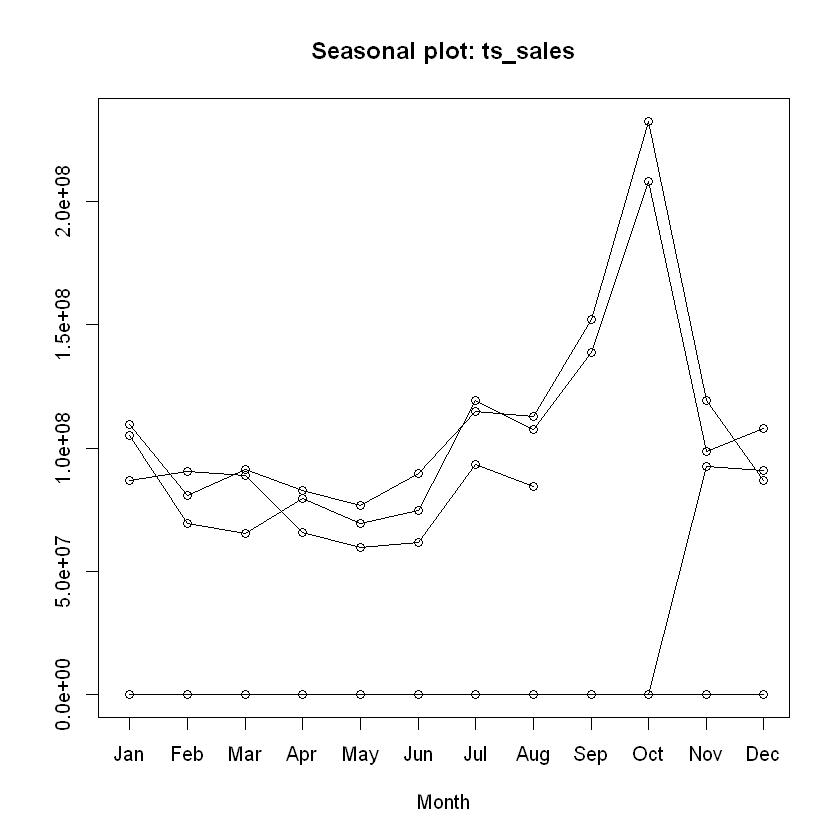

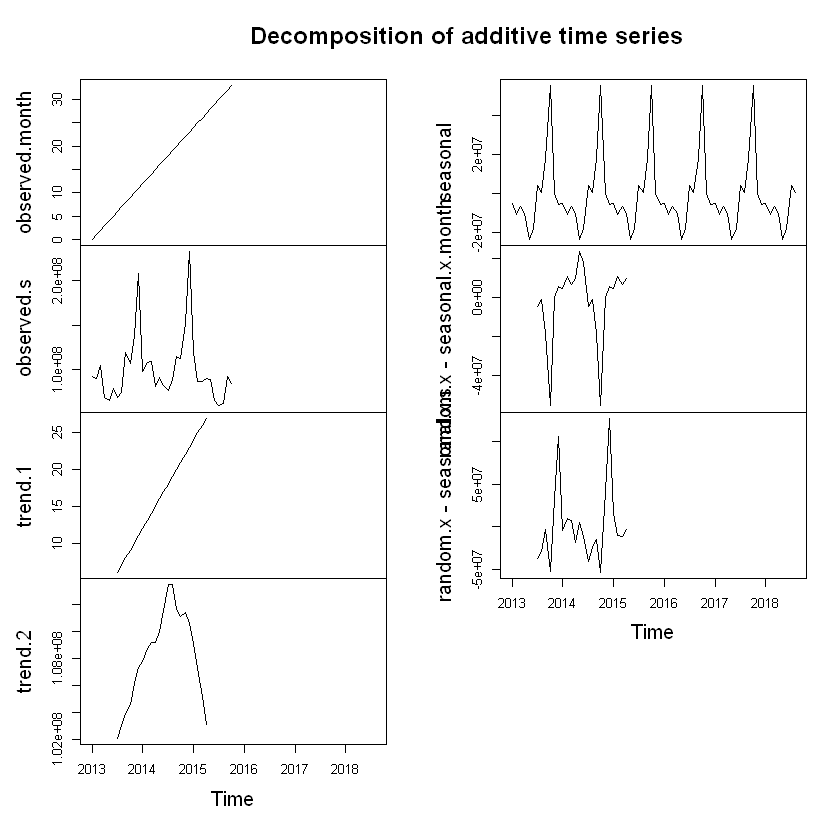

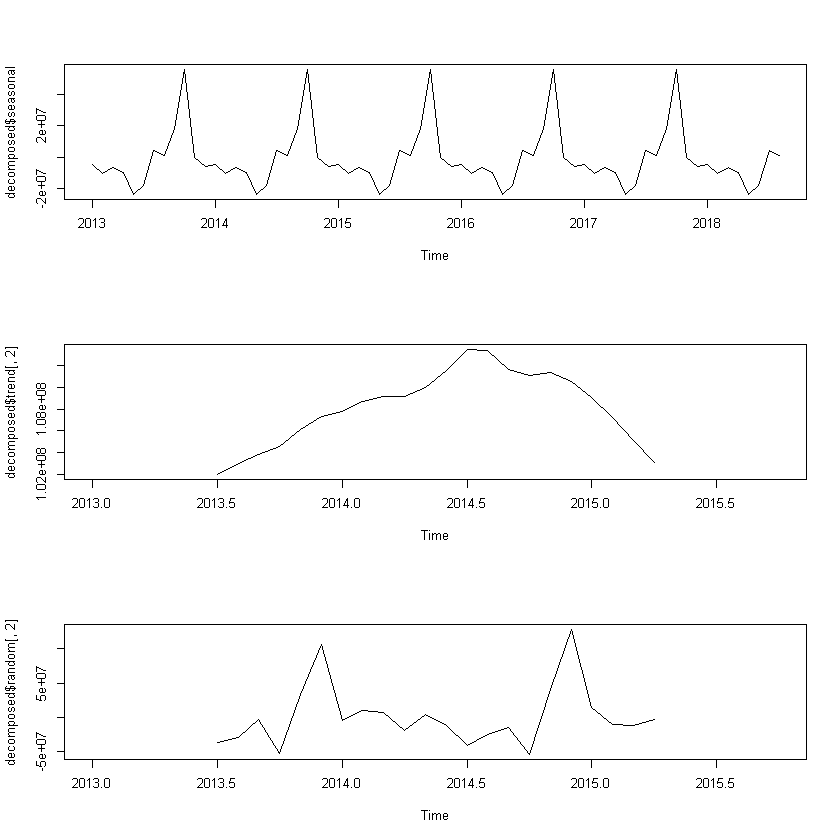

In [153]:
ts_sales = ts(sales_by_month, start = c(2013,1), frequency=12)
seasonplot(ts_sales)


decomposed = decompose(ts_sales)
plot(decomposed)

par(mfrow = c(3,1))
plot(decomposed$seasonal)
plot(decomposed$trend[,2])
plot(decomposed$random[,2])

In [154]:
#looks like there is definitely seasonality, so would have been best to use a model that is built for seasonal data